In [1]:
from gensim import downloader as gensim_api
from tensorflow import keras
import numpy as np

# word2vec-google-news-300
# glove-wiki-gigaword-200
glove_embedding = gensim_api.load('word2vec-google-news-300')
embedding_dim = len(glove_embedding['the'])

dataset = keras.datasets.imdb
word_index = dataset.get_word_index()
vocab_size = len(word_index) + 1

word_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if word in glove_embedding:
        word_matrix[i] = glove_embedding[word]

word_matrix.shape

2023-02-27 00:19:56.243900: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(88585, 300)

In [12]:
max_length = 200

(x_train, y_train), (x_test, y_test) = dataset.load_data(num_words=vocab_size)
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=max_length)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=max_length)

In [13]:
def create_model(feature_maps=64, filer_window=3, dropout_rate=0.5, l2_alpha=0.01, max_norm=3):
    print("Creating model with feature_maps={}, filer_window={}, dropout_rate={}, l2_alpha={}, max_norm={}".format(
        feature_maps, filer_window, dropout_rate, l2_alpha, max_norm))
    model = keras.Sequential([
        keras.layers.Embedding(vocab_size, embedding_dim, weights=[word_matrix], input_length=max_length, trainable=False),
        keras.layers.Conv1D(feature_maps, filer_window, activation='relu', 
                            kernel_regularizer=keras.regularizers.l2(l2_alpha), 
                            kernel_constraint=keras.constraints.max_norm(max_norm)),
        keras.layers.GlobalMaxPooling1D(),
        keras.layers.Dense(100, activation='relu'),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

Creating model with feature_maps=64, filer_window=3, dropout_rate=0.5, l2_alpha=0.01, max_norm=3
Epoch 1/10
313/313 [==============================] - 12s 35ms/step - loss: 0.8114 - accuracy: 0.6162 - val_loss: 0.6076 - val_accuracy: 0.7388
Epoch 2/10
313/313 [==============================] - 11s 35ms/step - loss: 0.5852 - accuracy: 0.7664 - val_loss: 0.5451 - val_accuracy: 0.8018
Epoch 3/10
313/313 [==============================] - 11s 35ms/step - loss: 0.5304 - accuracy: 0.8135 - val_loss: 0.6047 - val_accuracy: 0.7600
Epoch 4/10
313/313 [==============================] - 11s 35ms/step - loss: 0.4925 - accuracy: 0.8425 - val_loss: 0.5281 - val_accuracy: 0.8186
Epoch 5/10
313/313 [==============================] - 11s 35ms/step - loss: 0.4767 - accuracy: 0.8562 - val_loss: 0.5446 - val_accuracy: 0.8164
Epoch 6/10
313/313 [==============================] - 11s 36ms/step - loss: 0.4459 - accuracy: 0.8747 - val_loss: 0.5494 - val_accuracy: 0.8154
Epoch 7/10
313/313 [===================

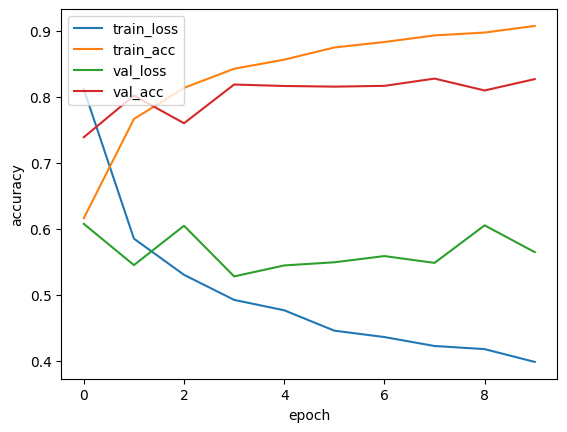

In [14]:
from matplotlib import pyplot as plt

model = create_model()
history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.2)
model.evaluate(x_test, y_test)

plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_loss', 'train_acc', 'val_loss', 'val_acc'], loc='upper left')
plt.show()

In [15]:
model.save('model.h5')